In [2]:
import os
from pinecone import Pinecone
from datasets import load_dataset
from warnings import filterwarnings

filterwarnings("ignore")

pinecone = Pinecone(api_key = "")

os.environ["OPENAI_API_KEY"] = ""

In [3]:
index = pinecone.Index("hybrid-image-search")

In [4]:
fashion = load_dataset("ashraq/fashion-product-images-small",
                       split= "train")

fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [5]:
fashion[0]

{'id': 15970,
 'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Shirts',
 'baseColour': 'Navy Blue',
 'season': 'Fall',
 'year': 2011.0,
 'usage': 'Casual',
 'productDisplayName': 'Turtle Check Men Navy Blue Shirt',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>}

In [6]:
images = fashion["image"]
metadata = fashion.remove_columns("image")

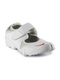

In [7]:
images[100]

In [8]:
metadata = metadata.to_pandas()
metadata

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44067,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44068,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44069,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44070,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [10]:
# import requests

# with open("pinecone_text.py", "w") as fb:
#     fb.write(requests.get(
#         "https://storage.googleapis.com/gareth-pinecone-datasets/pinecone_text.py"
#     ).text)

In [14]:
# from transformers import BertTokenizerFast
# import pinecone_text

# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# def tokenize_func(text):
#     token_ids = tokenizer(text, add_special_tokens = False)["input_ids"]
#     return tokenizer.convert_ids_to_tokens(token_ids)

In [15]:
# bm25 = pinecone_text.BM25(tokenize_func)

## Ignore 3 cells above, Have a new method

In [9]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diljy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diljy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

In [11]:
bm25.fit(metadata["productDisplayName"])

100%|██████████| 44072/44072 [00:03<00:00, 12761.98it/s]


In [12]:
metadata["productDisplayName"][0]

'Turtle Check Men Navy Blue Shirt'

In [13]:
bm25._encode_single_query(metadata["productDisplayName"][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [14]:
bm25.encode_documents(metadata["productDisplayName"][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

In [15]:
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SentenceTransformer("sentence-transformers/clip-Vit-B-32",
                            device = device)

model

SentenceTransformer(
  (0): CLIPModel()
)

In [17]:
dense_vec = model.encode([metadata["productDisplayName"][0]])
dense_vec.shape

(1, 512)

In [34]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    i_end = min(len(fashion), i+batch_size)

    metadata_batch = metadata[i:i_end]
    meta_dict = metadata_batch.to_dict(orient = "records")
    image_batch = images[i:i_end]
    ids = [str(x) for x in range(i,i_end)]
    metadata_batch = [" ".join(x) for x in metadata_batch.drop(["id", "year"], axis = 1).values.tolist()]

    sparse_embeds = bm25.encode_documents(metadata_batch)
    dense_embeds = model.encode(image_batch)
    upserts = []

    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            "id":_id,
            "sparse_values":sparse,
            "values": dense,
            "metadata": meta
        })
    index.upsert(upserts)

index.describe_index_stats()


100%|██████████| 221/221 [14:38<00:00,  3.97s/it]


{'dimension': 512,
 'index_fullness': 0.436,
 'namespaces': {'': {'vector_count': 43600}},
 'total_vector_count': 43600}

In [35]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k = 15,
    vector = dense,
    sparse_vector= sparse,
    include_metadata=True
)
result

{'matches': [{'id': '11868',
              'metadata': {'articleType': 'Jeans',
                           'baseColour': 'Blue',
                           'gender': 'Men',
                           'id': 9168.0,
                           'masterCategory': 'Apparel',
                           'productDisplayName': 'Locomotive Men Radley Blue '
                                                 'Jeans',
                           'season': 'Fall',
                           'subCategory': 'Bottomwear',
                           'usage': 'Casual',
                           'year': 2011.0},
              'score': 32.0932159,
              'values': []},
             {'id': '31163',
              'metadata': {'articleType': 'Jeans',
                           'baseColour': 'Blue',
                           'gender': 'Men',
                           'id': 9178.0,
                           'masterCategory': 'Apparel',
                           'productDisplayName': 'Locomotive Men Eer

In [36]:
result["matches"][0]

{'id': '11868',
 'metadata': {'articleType': 'Jeans',
              'baseColour': 'Blue',
              'gender': 'Men',
              'id': 9168.0,
              'masterCategory': 'Apparel',
              'productDisplayName': 'Locomotive Men Radley Blue Jeans',
              'season': 'Fall',
              'subCategory': 'Bottomwear',
              'usage': 'Casual',
              'year': 2011.0},
 'score': 32.0932159,
 'values': []}

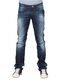

In [38]:
images[int(result["matches"][0]["id"])]

In [39]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [42]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Black Jeans
French Connection Men Grey Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans



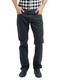
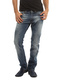
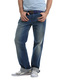
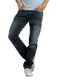
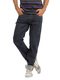
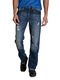
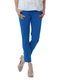
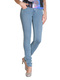
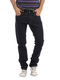
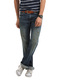
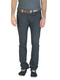
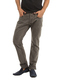
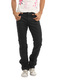
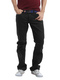

In [53]:
query = "dark blue french connection jeans for men"
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Barney Grey Jeans
Locomotive Men Lio Blue Jeans
John Players Men Blue Jeans
Locomotive Men Rafe Blue Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Locomotive Men Lain Blue Jeans



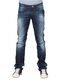
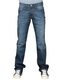
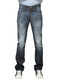
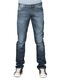
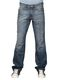
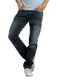
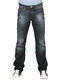
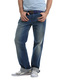
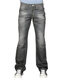
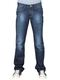
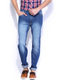
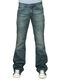
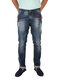
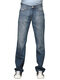

In [54]:
query = "dark blue french connection jeans for men"
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

French Connection Men Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Radley Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
Pepe Jeans Men Dark Blue Jeans



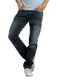
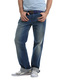
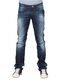
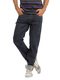
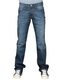
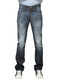
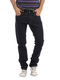
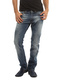
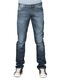
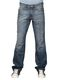
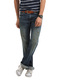
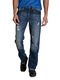
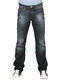
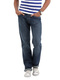

In [55]:
query = "dark blue french connection jeans for men"
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Baggit Women Blue Small Handbag
Kiara Women Small  Brown Handbag
Murcia Women Beige Handbag
Mod-acc Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Murcia Women Beige Handbag
Mod'acc Women Beige Handbag
Rocia Women Beige Handbag
Murcia Women Beige Handbag
Baggit Women Beige Handbag
Murcia Women Beige Handbag
Murcia Women Beige Handbag



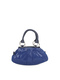
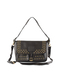
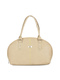
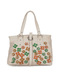
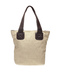
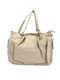
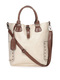
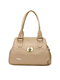
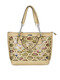
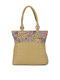
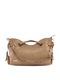
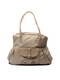
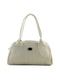
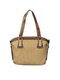

In [56]:
query = "small beige handbag for women"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Nyk Women Mustard Biker Sling Bag
Nyk Women Mushroom Brown Wallet
Rocky S Women Beige Handbag
Lino Perros Women Beige Handbag
Mod'acc Women Light Grey Coin Purse
Murcia Women Mauve Handbag
Baggit Women Golden Clutch
Kiara Women Beige Handbag
French Connection Women Beige Weave Clutch
Nyk Women Brown Alpine Handbag
Murcia Women Mary White Handbags
Baggit Women Beige Handbag
Kiara Women Burnt Yellow Sling Bag
OTLS Unisex Beige Messenger Bag



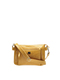
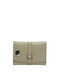
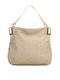
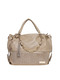
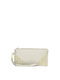
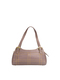
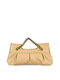
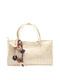
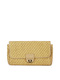
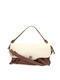
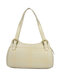
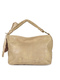
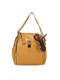
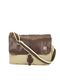

In [57]:
query = "small beige handbag for women"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Rocky S Women Beige Handbag
Lino Perros Women Beige Handbag
Kiara Women Beige Handbag
Baggit Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Murcia Women Beige Handbag
French Connection Women Beige Handbag
Murcia Women Hahk Beige Handbags
Murcia Women Hddcs Beige Handbags
Rocia Women Beige Handbag
Baggit Women Beige Handbag
Murcia Women Emma Beige Handbags
Murcia Women Emma Beige Handbags



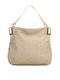
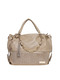
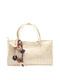
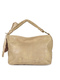
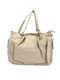
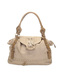
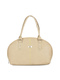
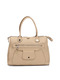
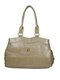
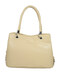
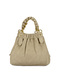
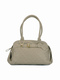
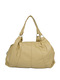
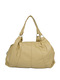

In [58]:
query = "small beige handbag for women"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

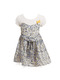

In [59]:
images[1500]

Doodle Girls Blue Printed Dress
Doodle Girls Blue Printed Dress
Doodle Kids Girl Printed Pink Dress
Doodle Girls Printed Blue Dress
Doodle Girls Printed Blue Dress
Doodle Girls Printed Multi Coloured Dress
Palm Tree Girls White Dress
Gini and Jony Girls White Dress
Doodle Girls Blue Printed Dress
Gini and Jony Girls Woven White Top
Doodle Girls Printed Pink Dress
Palm Tree Girl's Cr Blossom Drs Pink Dresses
Doodle Kids Girl Printed Off White Dress
United Colors of Benetton Kids Girls Pink Printed Dress



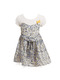
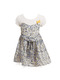
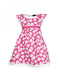
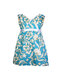
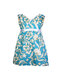
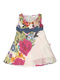
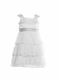
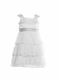
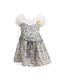
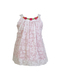
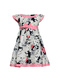
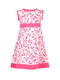
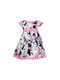
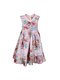

In [60]:
query = "beige top for women"

sparse = bm25.encode_queries(query)
dense = model.encode(images[1500]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

ONLY Women White Top
Jealous 21 Women Jealous Ranae White Top White Tops
Jealous 21 Women Jealous Cailyn White Top White Tops
Myntra Women White Top
Femella Women White Top
Tonga Women White Top
Nike Womens White Top
Elle Women White Top
Sepia Women White Top
Sepia Women Off White Top
ONLY Women Katie White Top
Mineral Women White Top
s.Oliver Women White Top
Elle Women White Tops



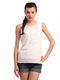
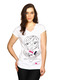
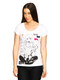
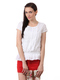
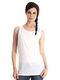
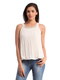
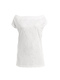
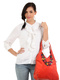
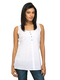
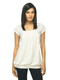
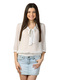
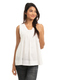
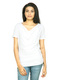
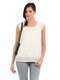

In [66]:
query = "White top for women"

sparse = bm25.encode_queries(query)
dense = model.encode(images[1500]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Gini and Jony Girls Woven White Top
Doodle Girl Little frock White Tops
Palm Tree Girls White Top
Palm Tree Girls White Dress
Gini and Jony Girls White Dress
Palm Tree Girls Beyonce White & Blue Dress
Little Miss Girls Blah White Top
Gini and Jony Girls Printed White Top
Gini and Jony Girls Printed White Top
Gini and Jony Girls Printed White Top
Little Miss Girls Blazing White Top
Doodle Kids Girls White I love Shopping Top
Gini and Jony Girls Knits White Top
Gini and Jony Girls Knits White Top



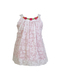
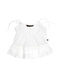
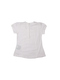
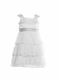
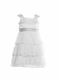
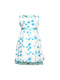
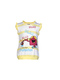
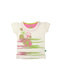
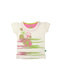
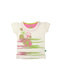
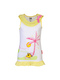
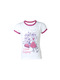
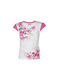
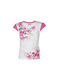

In [68]:
query = "White top for women"

sparse = bm25.encode_queries(query)
dense = model.encode(images[1500]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "White"}
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

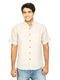

In [69]:
images[36256]

John Players Men Soft Check Shirt
Arrow Men Green Shirt
Wrangler Men Green Shirt
Arrow Men Green Shirt
Spykar Men Green Shirt
Myntra Men Green Shirt
Indigo Nation Men Checks Shirt Green Shirts
Indigo Nation Men Checks Shirt Green Shirts
Indigo Nation Men Checks Shirt Green Shirts
Indigo Nation Men Plain Shirt Green Shirts
Highlander Men Green Striped Shirt
Belmonte Men Check Green Shirts
Basics Men Green Striped Shirt
Turtle Men Check Green Shirt



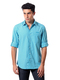
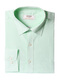
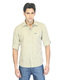
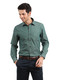
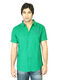
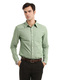
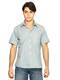
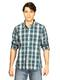
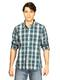
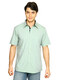
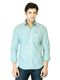
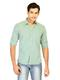
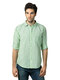
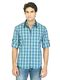

In [70]:
query = "soft green shirt for men"

sparse = bm25.encode_queries(query)
dense = model.encode(images[36256]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

Mother Earth Men Solid Beige Shirts
Peter England Men White Casual Shirt
John Players Men Solid White Shirt
John Players Men Striped White Shirt
Lee Men Solid Grey Shirts
Lee Men Check Yellow Shirts
French Connection Men White & Black Shirt
Mother Earth Men Solid White Shirt
Mother Earth Men White Shirt
Spykar Men Ranger White Full Shirts
Indian Terrain Men Blue Check Shirt
John Players Men Check Yellow Shirt
Mother Earth Men White Shirt
Scullers Men Scul Purple Shirts



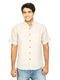
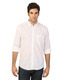
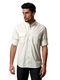
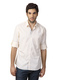
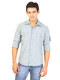
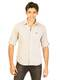
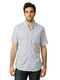
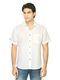
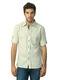
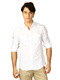
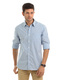
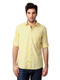
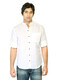
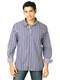

In [71]:
query = "soft green shirt for men"

sparse = bm25.encode_queries(query)
dense = model.encode(images[36256]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)

John Players Men Soft Check Shirt
Wrangler Men Green Shirt
Scullers Men Striped Green Shirt
Basics Men Green Checked Shirt
Wrangler Men Check Green Shirt
Wrangler Men Tiny Green Shirt
Scullers Men Check Green Shirts
Scullers Men Check Green Shirts
Lee Men Check Green Shirts
Scullers Men Check Green Shirts
Scullers Men Check Green Shirts
Indigo Nation Men Checks Shirt Green Shirts
Wrangler Men Stampede Green Shirt
John Players Men Check Green Shirt



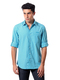
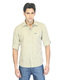
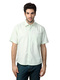
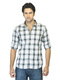
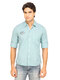
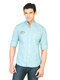
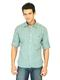
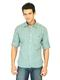
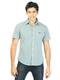
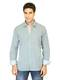
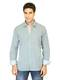
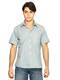
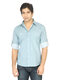
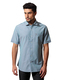

In [75]:
query = "soft green shirt for men"

sparse = bm25.encode_queries(query)
dense = model.encode(images[36256]).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.01)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]

#print Product names
for i in result["matches"]:
    print(i["metadata"]["productDisplayName"])
# display the images
display_result(imgs)